In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from scipy.spatial import KDTree
from matplotlib import colors
import yaml

import stuff
import plot

np.warnings.filterwarnings('ignore')

# Auto Photometry, bands R, G and I

## Configuration

In [2]:
print(open('/home/aalvarez/Work/Data/sim08/test_multiframe.config').read())

measurement-config-file=/home/aalvarez/Work/Data/sim08/config.yaml
output-properties=WorldCentroid,PixelCentroid,SourceIDs,SourceFlags,AutoPhotometry,AperturePhotometry
#,MultiframeModelFitting
detection-image=/home/aalvarez/Work/Data/sim08/sim08.fits
weight-image=/home/aalvarez/Work/Data/sim08/sim08.weight.fits
weight-type=weight
detection-image-saturation=59000
detection-image-gain=1
detect-minarea=10
partition-min-area=10
threads-nb=4
cellsize-value=32
partition-multithreshold=true
grouping-algorithm=SPLIT
checkimage-residual=/home/aalvarez/Work/Data/sim08/mci_residual.fits
checkimage-modelfitting=/home/aalvarez/Work/Data/sim08/mci_modelfitting.fits
checkimage-background=/home/aalvarez/Work/Data/sim08/mci_background.fits
checkimage-variance=/home/aalvarez/Work/Data/sim08/mci_variance.fits
checkimage-segmentation=/home/aalvarez/Work/Data/sim08/mci_segmentation.fits
checkimage-partition=/home/aalvarez/Work/Data/sim08/mci_partition.fits
checkimage-filtered=/home/aalvarez/Work/Data/sim0

In [3]:
multiframe_config = yaml.load(open('/home/aalvarez/Work/Data/sim08/config.yaml'))
print(yaml.dump(multiframe_config))

- measurements-group:
    image-files:
    - {path: /home/aalvarez/Work/Data/sim08/sim08_g_*.fits, psf-path: /home/aalvarez/Work/Data/sim08/sim08_g_*.psf}
    name: g
- measurements-group:
    image-files:
    - {path: /home/aalvarez/Work/Data/sim08/sim08_r_*.fits, psf-path: /home/aalvarez/Work/Data/sim08/sim08_r_*.psf}
    name: r
- measurements-group:
    image-files:
    - {path: /home/aalvarez/Work/Data/sim08/sim08_i_*.fits, psf-path: /home/aalvarez/Work/Data/sim08/sim08_i_*.psf}
    name: i



## Load simulation data

In [4]:
r_stars, r_galaxies = stuff.parse_stuff_list('/home/aalvarez/Work/Data/sim08/sim08_r.list')
g_stars, g_galaxies = stuff.parse_stuff_list('/home/aalvarez/Work/Data/sim08/sim08_g.list')
i_stars, i_galaxies = stuff.parse_stuff_list('/home/aalvarez/Work/Data/sim08/sim08_i.list')

### Build a KDTree with the source coordinates

In [5]:
# Make sure that the coordinates are the same for all simulations!
assert(np.all(r_stars.ra == g_stars.ra) and np.all(r_stars.dec == g_stars.dec))
assert(np.all(r_galaxies.ra == g_galaxies.ra) and np.all(r_galaxies.dec == g_galaxies.dec))
assert(np.all(r_galaxies.ra == i_galaxies.ra) and np.all(r_galaxies.dec == i_galaxies.dec))

kdtree, n_stars, n_galaxies = stuff.index_sources(r_stars, r_galaxies)

n_stars = len(r_stars)
n_galaxies = len(r_galaxies)

r_mags = np.append(r_stars.mag, r_galaxies.mag)
g_mags = np.append(g_stars.mag, g_galaxies.mag)
i_mags = np.append(i_stars.mag, i_galaxies.mag)

## Load the output catalog
**NOTICE**: Flags are aggregated by group, so each flag column with have an array with 3 elements, in *alphabetical order* (g, i, h)

In [6]:
output_catalog = Table.read('/home/aalvarez/Work/Data/sim08/multiframe_output.fits')

Compute average magnitudes taking into account the exposure time, since the magnitude field on the catalog doesn't.

In [7]:
# This comes from sim09_*_sky.conf
mag_zeropoint = 26.
exp_time = 300.

In [8]:
# Need to massage the catalog first
for i in range(10):
    for b in ['r', 'g', 'i']:
        auto_mag_cname = f'auto_mag_{b}_{i}'
        flux_cname = f'auto_flux_{b}_{i}'
        mag_cname = f'mag_{b}_{i}'
        # Replace 99 with nan to make filtering easier
        output_catalog[auto_mag_cname][output_catalog[auto_mag_cname] >= 99.] = np.nan
        output_catalog[flux_cname][output_catalog[flux_cname] == 0.] = np.nan
        # Compute he magnitude for each frame
        output_catalog[mag_cname] = mag_zeropoint - 2.5 * np.log10(output_catalog[flux_cname] / exp_time)

In [9]:
# Aggregate the fluxes and magnitudes per band
for b in ['r', 'g', 'i']:
    output_catalog[f'auto_flux_{b}'] = np.nanmean(np.array([output_catalog[f'auto_flux_{b}_{i}'] for i in range(10)]), axis=0)
    output_catalog[f'{b}_mag'] = np.nanmean(np.array([output_catalog[f'mag_{b}_{i}'] for i in range(10)]), axis=0)
    output_catalog[f'{b}_mag_med'] = np.nanmedian(np.array([output_catalog[f'mag_{b}_{i}'] for i in range(10)]), axis=0)
    output_catalog[f'{b}_mag_max'] = np.nanmax(np.array([output_catalog[f'mag_{b}_{i}'] for i in range(10)]), axis=0) - output_catalog[f'{b}_mag']
    output_catalog[f'{b}_mag_min'] = output_catalog[f'{b}_mag'] - np.nanmin(np.array([output_catalog[f'mag_{b}_{i}'] for i in range(10)]), axis=0)

## Compare results

In [10]:
closest = stuff.get_closest(output_catalog, kdtree)

In [11]:
print("Number of sources found:", len(closest['dist']))

Number of sources found: 1443


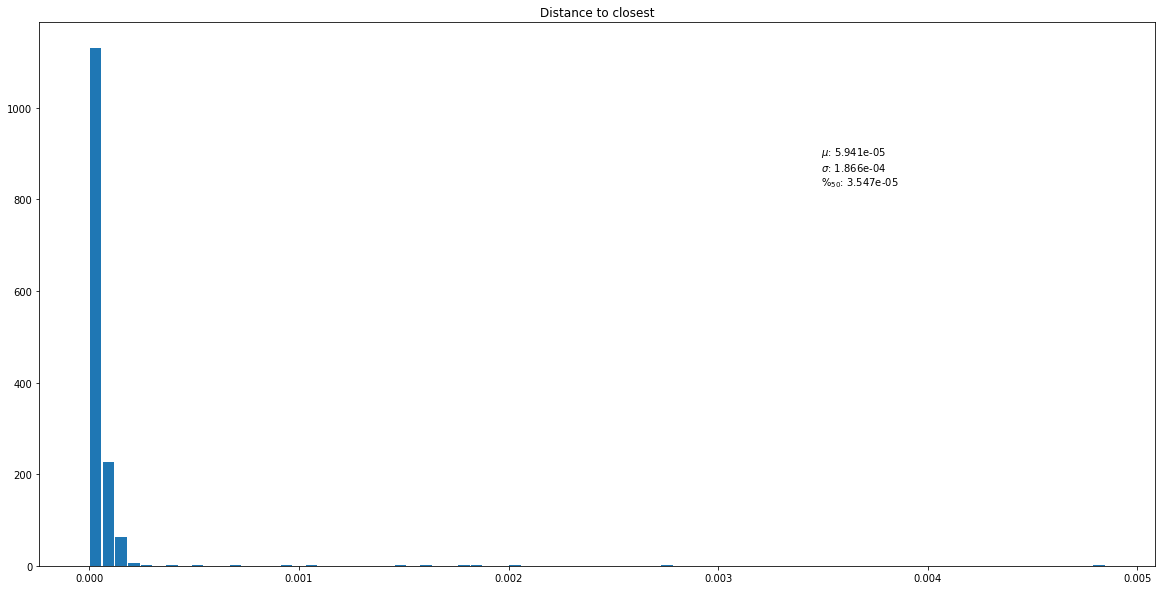

In [12]:
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 1, 1)
ax1.hist(closest['dist'], 80, rwidth=0.9)
plot.add_stats(ax1, closest['dist'])
_ = ax1.set_title('Distance to closest')

### Magnitudes

In [13]:
# Compute difference between obtained and expected magnitudes, using the average
r_mag_diff = output_catalog[closest['catalog']]['r_mag'] - r_mags[closest['source']]
g_mag_diff = output_catalog[closest['catalog']]['r_mag'] - g_mags[closest['source']]
i_mag_diff = output_catalog[closest['catalog']]['i_mag'] - i_mags[closest['source']]

# Compute difference between obtained and expected magnitudes, using the median
r_mag_med_diff = output_catalog[closest['catalog']]['r_mag_med'] - r_mags[closest['source']]
g_mag_med_diff = output_catalog[closest['catalog']]['r_mag_med'] - g_mags[closest['source']]
i_mag_med_diff = output_catalog[closest['catalog']]['i_mag_med'] - i_mags[closest['source']]

# Filter NaN and outliers
r_not_nan = (np.isnan(r_mag_diff) == False)
g_not_nan = (np.isnan(g_mag_diff) == False)
i_not_nan = (np.isnan(i_mag_diff) == False)
r_outlier_filter = (r_mag_diff >= np.percentile(r_mag_diff[r_not_nan], 5)) & (r_mag_diff <= np.percentile(r_mag_diff[r_not_nan], 95)) & r_not_nan
g_outlier_filter = (g_mag_diff >= np.percentile(g_mag_diff[g_not_nan], 5)) & (g_mag_diff <= np.percentile(g_mag_diff[g_not_nan], 95)) & g_not_nan
i_outlier_filter = (i_mag_diff >= np.percentile(i_mag_diff[i_not_nan], 5)) & (i_mag_diff <= np.percentile(i_mag_diff[i_not_nan], 95)) & i_not_nan

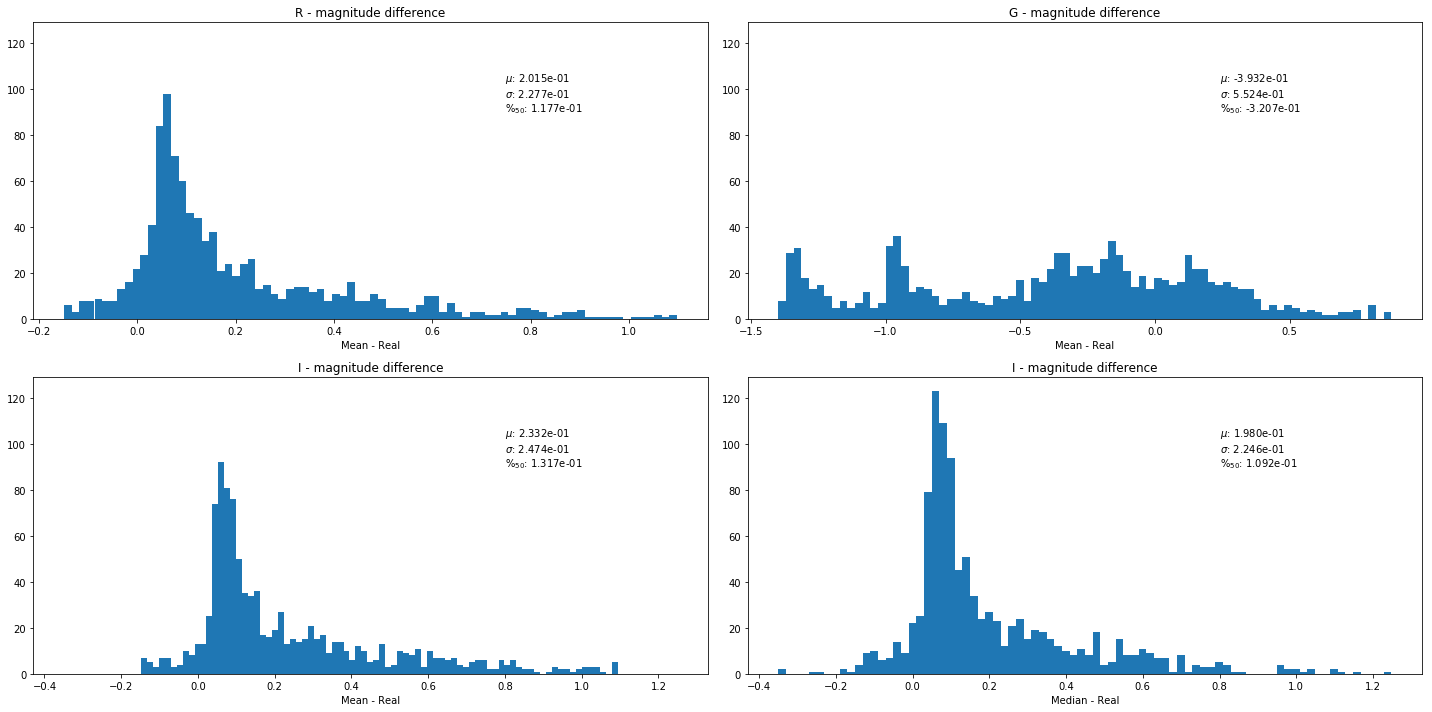

In [14]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2, 2, 1)
ax1.hist(r_mag_diff[r_outlier_filter], 80)
ax1.set_xlabel('Mean - Real')
plot.add_stats(ax1, r_mag_diff[r_outlier_filter])
ax1.set_title('R - magnitude difference')

ax2 = plt.subplot(2, 2, 2, sharey=ax1)
ax2.hist(g_mag_diff[g_outlier_filter], 80)
ax2.set_xlabel('Mean - Real')
plot.add_stats(ax2, g_mag_diff[g_outlier_filter])
_ = ax2.set_title('G - magnitude difference')

ax3 = plt.subplot(2, 2, 3, sharey=ax1)
ax3.hist(i_mag_diff[i_outlier_filter], 80)
ax3.set_xlabel('Mean - Real')
plot.add_stats(ax3, i_mag_diff[i_outlier_filter])
_ = ax3.set_title('I - magnitude difference')

ax4 = plt.subplot(2, 2, 4, sharey=ax1, sharex=ax3)
ax4.hist(i_mag_med_diff[i_outlier_filter], 80)
ax4.set_xlabel('Median - Real')
plot.add_stats(ax4, i_mag_med_diff[i_outlier_filter])
_ = ax4.set_title('I - magnitude difference')

plt.tight_layout()

Looking at these plots, it seems that the computed magnitude tends to be greater: the flux is underestimated.

In [15]:
# Aggregate flags per band
saturated_flag = (output_catalog[closest['catalog']]['source_flags'] & 4).sum(axis=1).astype(np.bool)
auto_flag = (output_catalog[closest['catalog']]['auto_flags']).astype(np.bool)

g_flag = auto_flag[:,0] | saturated_flag
i_flag = auto_flag[:,1] | saturated_flag
r_flag = auto_flag[:,2] | saturated_flag


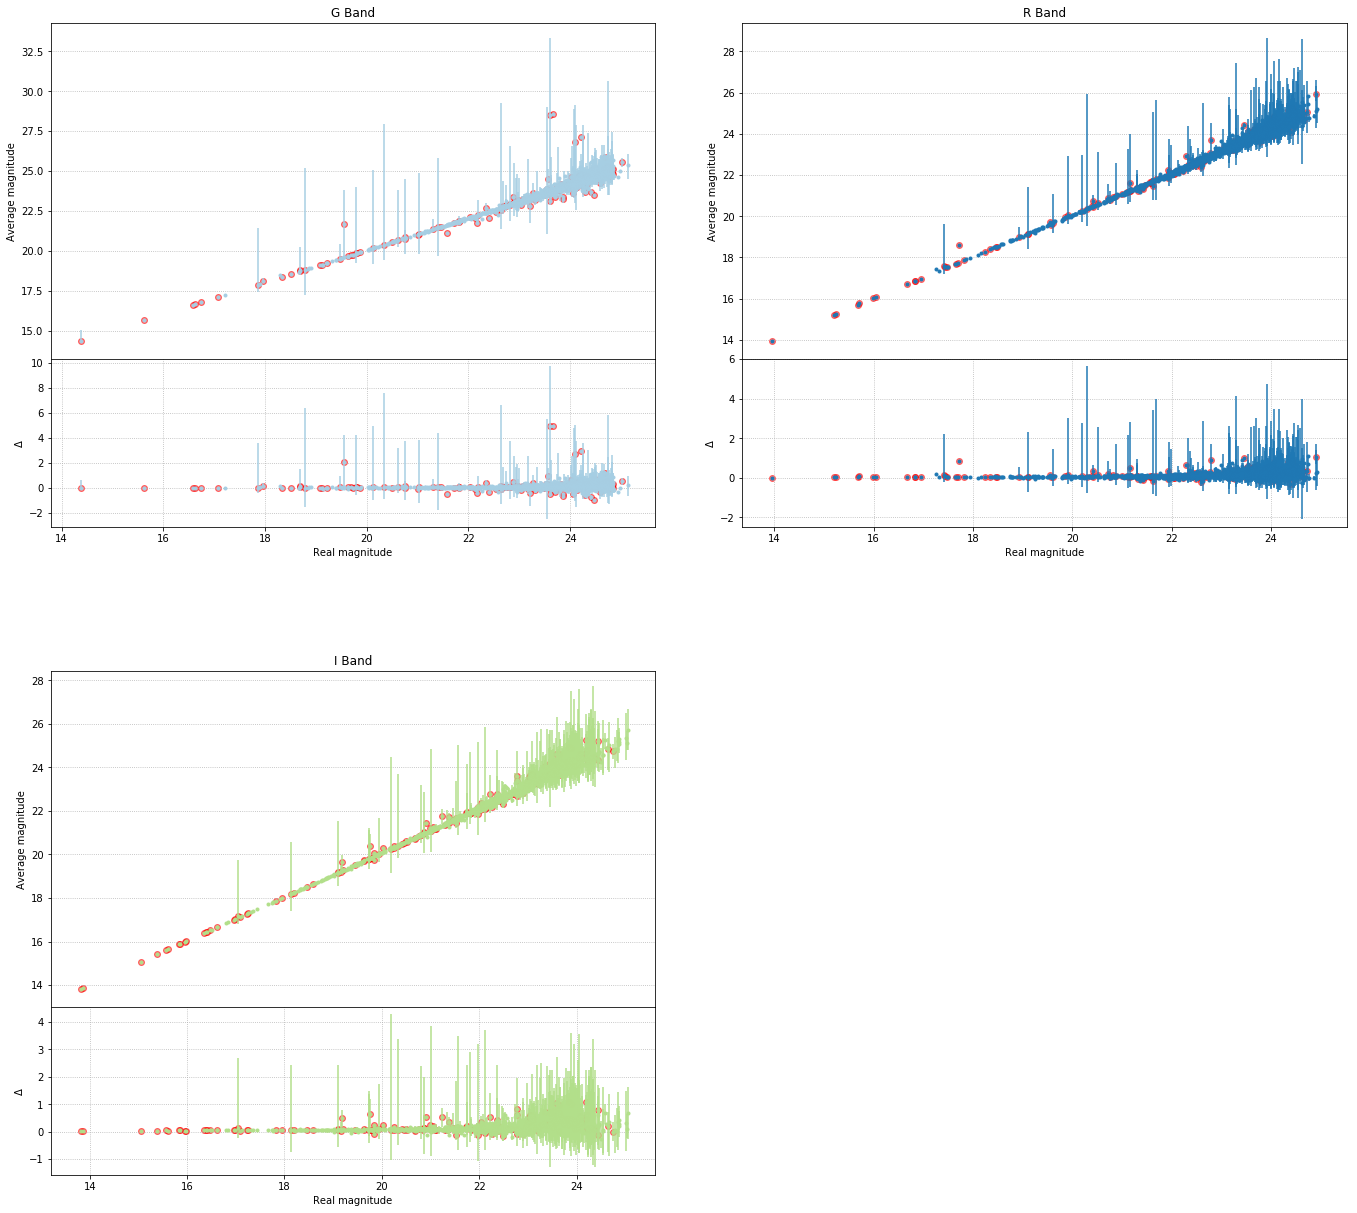

In [16]:
plot.scatter_delta([
    (
        g_mags[closest['source']][g_outlier_filter], output_catalog[closest['catalog']]['g_mag_med'][g_outlier_filter],
        [output_catalog['g_mag_min'][g_outlier_filter], output_catalog['g_mag_max'][g_outlier_filter]],
        g_flag[g_outlier_filter], 'G Band'
    ),
    (
        r_mags[closest['source']][r_outlier_filter], output_catalog[closest['catalog']]['r_mag_med'][r_outlier_filter],
        [output_catalog['r_mag_min'][r_outlier_filter], output_catalog['r_mag_max'][r_outlier_filter]],
        r_flag[r_outlier_filter], 'R Band'
    ),
    (
        i_mags[closest['source']][i_outlier_filter], output_catalog[closest['catalog']]['i_mag_med'][i_outlier_filter],
        [output_catalog['i_mag_min'][i_outlier_filter], output_catalog['i_mag_max'][i_outlier_filter]],
        i_flag[i_outlier_filter], 'I Band'
    ),
], figsize=(20,20), ylabel='Average magnitude', ydeltalabel='$\Delta$', xlabel='Real magnitude')

Flagged sources are highlighted in red. Error bars range from the minimum to the maxtimum magnitude value. Some sources are 'dragged' outside their expected position due to very low fluxes estimated on some frames. These are (mostly?) due to apertures barely 'touching' a frame. For instance:

In [17]:
output_catalog[output_catalog['i_mag_max'] > 5][['source_id'] + [f'auto_flux_i_{i}' for i in range(10)]]

source_id,auto_flux_i_0,auto_flux_i_1,auto_flux_i_2,auto_flux_i_3,auto_flux_i_4,auto_flux_i_5,auto_flux_i_6,auto_flux_i_7,auto_flux_i_8,auto_flux_i_9
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
187,62434.74609375,62166.484375,nan,60712.58984375,nan,nan,62053.99609375,103.0595703125,nan,nan
235,2571.310302734375,nan,nan,801.01708984375,nan,5.43603515625,3710.438232421875,1108.248779296875,2597.90380859375,nan


Both source have wildly different fluxes for different frames. Checking the aperture for this in auto_flux_i7.

In [18]:
aperture_data = fits.open('/home/aalvarez/Work/Data/sim08/mci_auto.fits.27')[0].data
aperture_data[aperture_data != 187] = 0
print((aperture_data == 187).sum())

5


The aperture just "touches" 5 pixels on that frame. The flag is set nevertheless, but it doesn't specify the particular frame where the issue is.

## Display outliers
Not flagged, but bad quality

In [19]:
# Display non flagged sources with a big error
big_error = (np.abs(i_mag_med_diff) > 1.0) & ~i_flag

flux_overestimated = i_mag_diff < 0
flux_underestimated = i_mag_diff > 0

In [20]:
output_catalog[big_error][['source_id', 'pixel_centroid_x', 'pixel_centroid_y', 'auto_flags', 'i_mag'] + [f'auto_flux_i_{i}' for i in range(10)]]

source_id,pixel_centroid_x,pixel_centroid_y,auto_flags [3],i_mag,auto_flux_i_0,auto_flux_i_1,auto_flux_i_2,auto_flux_i_3,auto_flux_i_4,auto_flux_i_5,auto_flux_i_6,auto_flux_i_7,auto_flux_i_8,auto_flux_i_9
int32,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
84,1833.3155517578125,625.4859619140625,8 .. 0,25.76089271550667,nan,795.164306640625,nan,175.8212890625,nan,nan,nan,nan,nan,nan
108,1164.7906494140625,703.4909057617188,0 .. 0,25.03697342433088,nan,nan,nan,728.336181640625,nan,nan,nan,nan,nan,nan
274,2570.072509765625,1047.088134765625,0 .. 0,25.517703852779867,1115.402099609375,nan,nan,191.8427734375,nan,822.746826171875,-212.9554443359375,1066.5703125,119.279541015625,nan
287,3124.33154296875,1069.8760986328125,0 .. 0,24.965868169086928,695.125,nan,nan,nan,nan,nan,869.9315185546875,nan,nan,nan
292,2053.49462890625,1078.303466796875,0 .. 0,24.807138750565347,444.6533203125,2372.189697265625,nan,609.739013671875,nan,517.743896484375,671.5072021484375,2377.4638671875,nan,nan
293,946.5036010742188,1081.996826171875,0 .. 0,22.919529457997758,nan,nan,nan,5120.4658203125,nan,nan,nan,nan,nan,nan
330,2329.21875,1161.34814453125,0 .. 0,26.220334500745803,-309.740234375,338.80224609375,nan,-58.97998046875,nan,692.309814453125,64.767333984375,272.93603515625,212.458251953125,nan
353,1124.8966064453125,1211.23876953125,0 .. 0,25.07019891249905,nan,1103.345458984375,nan,426.546875,nan,1276.54638671875,nan,414.4306640625,nan,nan
362,1374.6536865234375,1231.810302734375,0 .. 0,25.54633539467039,nan,506.838134765625,nan,1143.2509765625,nan,503.25927734375,354.588623046875,189.848876953125,nan,nan


In [21]:
np.average(output_catalog[big_error]['i_mag'])

25.249524625975067

Really on the very faint side.

In [22]:
aperture_img = fits.open('/home/aalvarez/Work/Data/sim08/mci_auto.fits')[0]
coadd_img_i = fits.open('/home/aalvarez/Work/Data/sim08/sim08_i.fits')[0]

In [23]:
some_id = (aperture_img.data > 0).astype(np.float)
aperture_mask = np.ones(aperture_img.shape + (4,))
aperture_mask[:,:,0] = some_id
aperture_mask[:,:,1] = some_id * 0.5
aperture_mask[:,:,2] = some_id * 0.5
aperture_mask[:,:,3] = some_id * 0.4

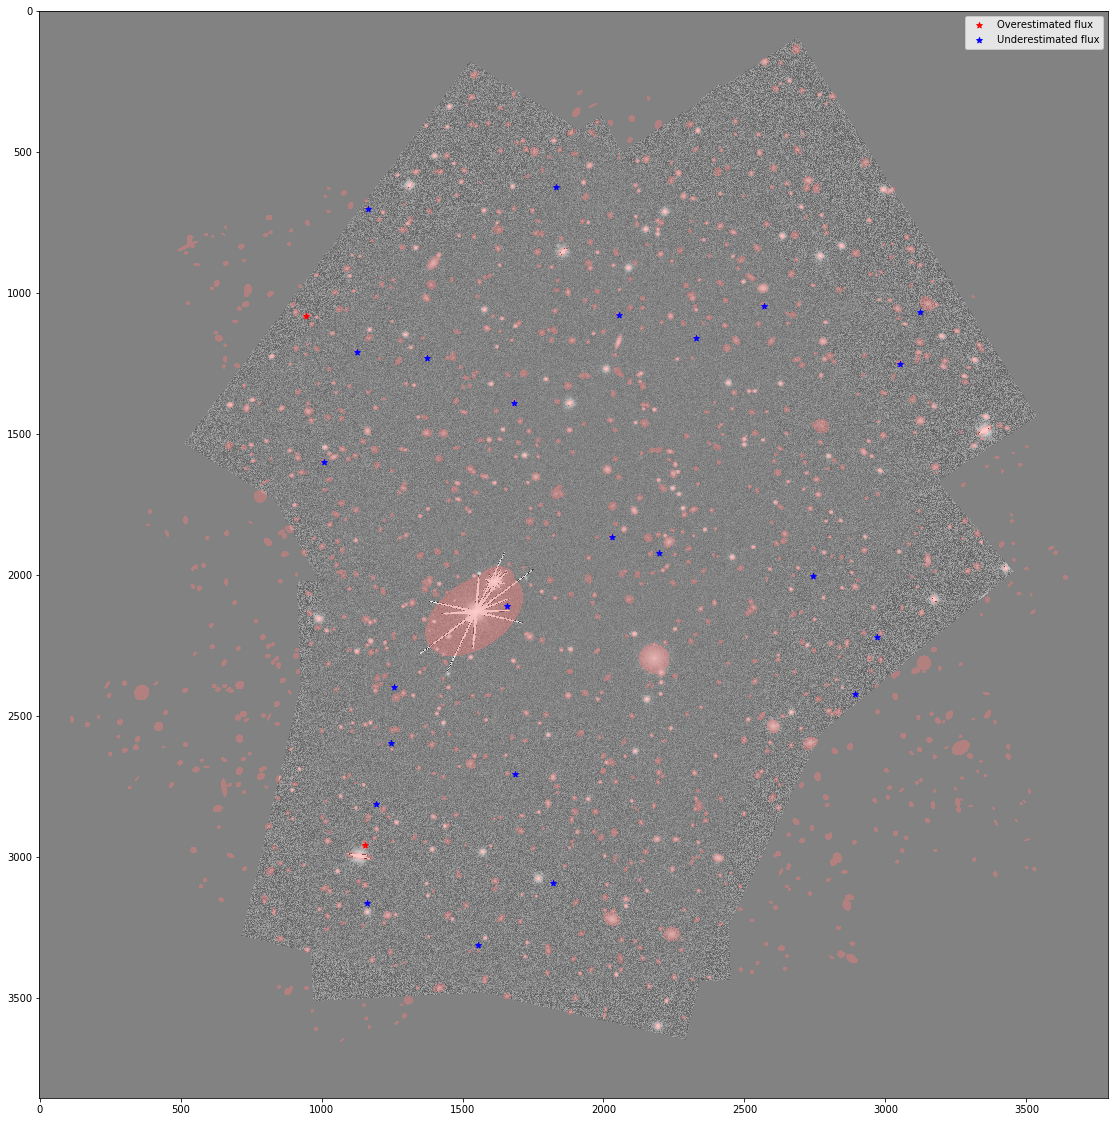

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(coadd_img_i.data, norm=colors.SymLogNorm(50), cmap=plt.get_cmap('Greys_r'))
plt.imshow(aperture_mask)
plt.scatter(
    output_catalog[big_error & flux_overestimated]['pixel_centroid_x'],
    output_catalog[big_error & flux_overestimated]['pixel_centroid_y'],
    marker='*', c='red', label='Overestimated flux'
)
plt.scatter(
    output_catalog[big_error & flux_underestimated]['pixel_centroid_x'],
    output_catalog[big_error & flux_underestimated]['pixel_centroid_y'],
    marker='*', c='blue', label='Underestimated flux'
)
plt.legend()